<a href="https://colab.research.google.com/github/Romandancer1/object-detection-example/blob/master/racoon-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/experiencor/raccoon_dataset.git

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (412/412), done.


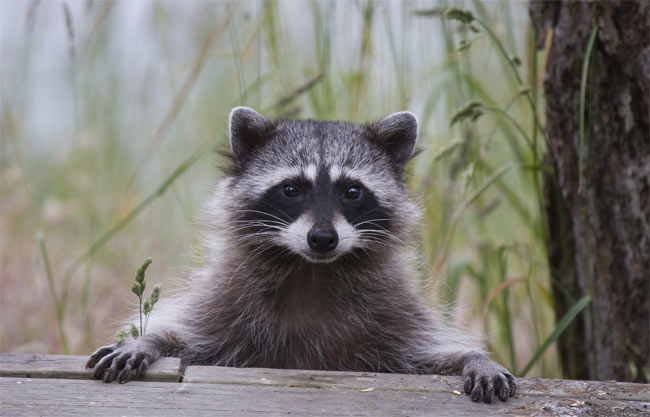

In [ ]:
from PIL import Image
image = Image.open("raccoon_dataset/images/raccoon-1.jpg")
image

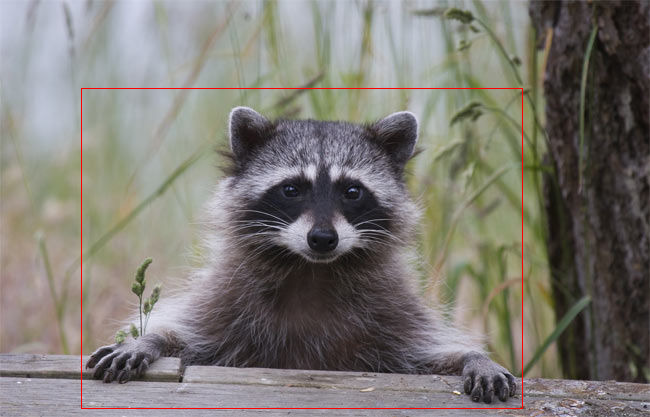

In [ ]:
from PIL import ImageDraw
xmin = 81
ymin = 88
xmax = 522
ymax = 408
draw = ImageDraw.Draw(image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline ='red')
image

In [ ]:
import pandas as pd
labels = pd.read_csv("raccoon_dataset/data/raccoon_labels.csv")
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-1.jpg,650,417,raccoon,81,88,522,408
1,raccoon-10.jpg,450,495,raccoon,130,2,446,488
2,raccoon-100.jpg,960,576,raccoon,548,10,954,520
3,raccoon-101.jpg,640,426,raccoon,86,53,400,356
4,raccoon-102.jpg,259,194,raccoon,1,1,118,152


In [ ]:
import pycocotools

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [ ]:
def parse_one_annot(path_to_data_file, filename):
   data = pd.read_csv(path_to_data_file)
   boxes_array = data[data["filename"] == filename][["xmin", "ymin",        
   "xmax", "ymax"]].values
   
   return boxes_array

In [ ]:
class RaccoonDataset(torch.utils.data.Dataset):
   def __init__(self, root, data_file, transforms=None):
       self.root = root
       self.transforms = transforms
       self.imgs = sorted(os.listdir(os.path.join(root, "images")))
       self.path_to_data_file = data_file
   def __getitem__(self, idx):
        # Загрузка боксов и картинок
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.path_to_data_file, 
        self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        # У нас только один класс
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,
        0])
      
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
     
   def __len__(self):
      return len(self.imgs)

In [ ]:
import os
dataset = RaccoonDataset(root= "raccoon_dataset",
data_file= "raccoon_dataset/data/raccoon_labels.csv")
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7F52069F42E8>,
 {'area': tensor([141120.]),
  'boxes': tensor([[ 81.,  88., 522., 408.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1])})

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_model(num_classes):
   # Загружаем предобученную модель
   model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   in_features = model.roi_heads.box_predictor.cls_score.in_features
   model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
   
   return model

In [ ]:
def get_transform(train):
   transforms = []
   # Преобразование входной картинки в тензоры
   transforms.append(T.ToTensor())
   if train:
      # Добавим аугментацию
      transforms.append(T.RandomHorizontalFlip(0.5))
   return T.Compose(transforms)

In [ ]:
import torchvision
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# У нас только два класса - енот и не енот
num_classes = 2
# Получаем модель для детекции
model = get_model(num_classes)
# Все вычисления переводим на gpu
model.to(device)
# Функция для оптимизации learning rate
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# Снижаем learning rate каждые 3 эпохи на 0.1
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# Создаем класс заново для обучения
dataset = RaccoonDataset(root= "raccoon_dataset",
          data_file= "raccoon_dataset/data/raccoon_labels.csv",
          transforms = get_transform(train=True))
dataset_test = RaccoonDataset(root= "raccoon_dataset",
               data_file= "raccoon_dataset/data/raccoon_labels.csv",
               transforms = get_transform(train=False))
# Делим датасет на train и val
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])
# Обьявляем загрузчики для обучения
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=4,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=4,
         collate_fn=utils.collate_fn)
print("{} train {} test".format(len(dataset), len(dataset_test)))

160 train 40 test


In [ ]:
# Обучаем 10 эпох
num_epochs = 10
for epoch in range(num_epochs):
   # выводим каждые 10 итерация
   train_one_epoch(model, optimizer, data_loader, device, epoch,print_freq=10)
   # Обновляем learining rate
   lr_scheduler.step()
   # После каждой эпохи запускаем валидацию на тестовой выборке
   evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/80]  eta: 0:03:44  lr: 0.000068  loss: 0.9683 (0.9683)  loss_classifier: 0.8440 (0.8440)  loss_box_reg: 0.1141 (0.1141)  loss_objectness: 0.0079 (0.0079)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 2.8077  data: 0.3125  max mem: 2113
Epoch: [0]  [10/80]  eta: 0:02:00  lr: 0.000701  loss: 0.6382 (0.6380)  loss_classifier: 0.4635 (0.4663)  loss_box_reg: 0.1303 (0.1553)  loss_objectness: 0.0066 (0.0065)  loss_rpn_box_reg: 0.0052 (0.0098)  time: 1.7277  data: 0.0360  max mem: 3055
Epoch: [0]  [20/80]  eta: 0:01:39  lr: 0.001333  loss: 0.4232 (0.4952)  loss_classifier: 0.2091 (0.3258)  loss_box_reg: 0.1436 (0.1537)  loss_objectness: 0.0033 (0.0047)  loss_rpn_box_reg: 0.0062 (0.0111)  time: 1.6089  data: 0.0084  max mem: 3055
Epoch: [0]  [30/80]  eta: 0:01:23  lr: 0.001965  loss: 0.2357 (0.4083)  loss_classifier: 0.0999 (0.2444)  loss_box_reg: 0.1199 (0.1464)  loss_objectness: 0.0014 (0.0055)  loss_rpn_box_reg: 0.0106 (0.0121)  time: 1.6278  data: 0.0085  max mem: 3440
Epoch: [

In [ ]:

torch.save(model.state_dict(),'./model/racoon.pth')

In [ ]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load('model/racoon.pth'))

<All keys matched successfully>

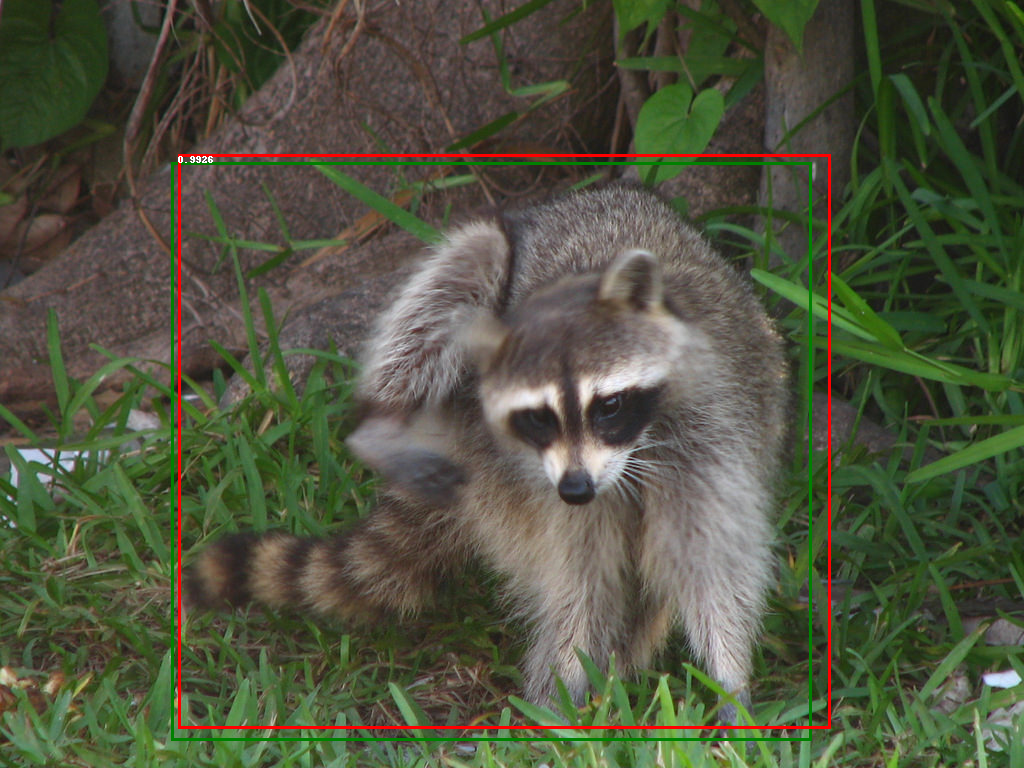

In [ ]:
idx = 0
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#переводим модель в режим эмуляции
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# Отрисовываем лейблы на картинке
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image